## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt   # data visualization
pd.options.mode.chained_assignment = None  # suppress DataFrame slice warning

## Read input data

### Extract BTC data from input

In [2]:
df = pd.read_csv('/kaggle/input/-cryptocurrency-historical-prices-dataset/dataset.csv')

In [3]:
btc = df.loc[df['crypto_name'] == 'Bitcoin'].copy()

In [4]:
btc = btc.set_index('date')
btc.index = pd.to_datetime(btc.index)
btc

,Unnamed: 0,open,high,low,close,volume,marketCap,timestamp,crypto_name
date,,,,,,,,,
2013-05-05,0,112.900002,118.800003,107.142998,115.910004,0.000000e+00,1.288693e+09,2013-05-05T23:59:59.999Z,Bitcoin
2013-05-06,2,115.980003,124.663002,106.639999,112.300003,0.000000e+00,1.249023e+09,2013-05-06T23:59:59.999Z,Bitcoin
2013-05-07,4,112.250000,113.444000,97.699997,111.500000,0.000000e+00,1.240594e+09,2013-05-07T23:59:59.999Z,Bitcoin
2013-05-08,7,109.599998,115.779999,109.599998,113.566002,0.000000e+00,1.264049e+09,2013-05-08T23:59:59.999Z,Bitcoin
2013-05-09,9,113.199997,113.459999,109.260002,112.669998,0.000000e+00,1.254535e+09,2013-05-09T23:59:59.999Z,Bitcoin
...,...,...,...,...,...,...,...,...,...
2022-09-25,72692,18936.311515,19134.733194,18696.468304,18802.097976,2.335997e+10,3.602593e+11,2022-09-25T23:59:59.999Z,Bitcoin
2022-10-02,72752,19311.848708,19370.309281,18970.620583,19044.107272,2.076596e+10,3.650248e+11,2022-10-02T23:59:59.999Z,Bitcoin
2022-10-09,72815,19417.479411,19542.538654,19349.258953,19446.426194,1.683726e+10,3.728768e+11,2022-10-09T23:59:59.999Z,Bitcoin


### Visualize extracted data

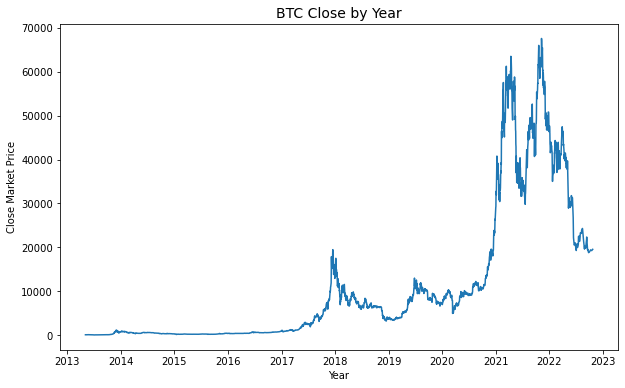

In [5]:
# Plot btc 'close' column
plt.figure(figsize=(10,6))
plt.title('BTC Close by Year', fontsize=14)
plt.ylabel('Close Market Price')
plt.xlabel('Year')
plt.plot(btc['close'])

## Time Series Data Analysis

### Get decomposition of the data

<Figure size 1152x1008 with 0 Axes>

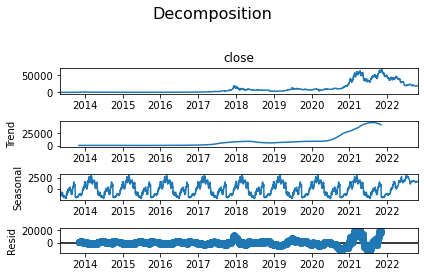

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Decomposition, annually as period
decomposition = seasonal_decompose(btc['close'], period=365)

# Plot
plt.figure(figsize=(16,14))
decomposition.plot().suptitle('Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

* Decomposition of data suggests a trend in the later years. 
* The series is not seasonal due to the spikes in price values. 

We can now work toward detrend the series and check for stationarity.

### Standardize the data

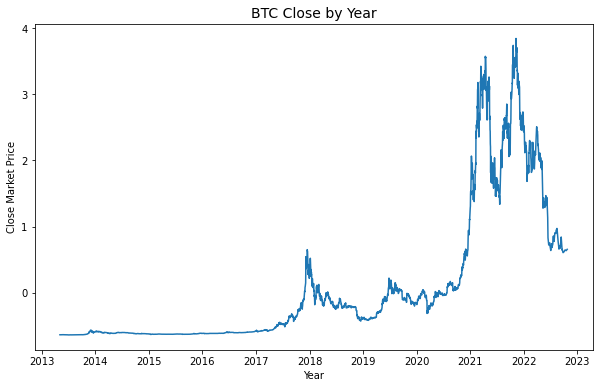

In [7]:
close_mean, close_std = btc['close'].mean(), btc['close'].std()
btc['close'] = (btc['close'] - close_mean) / close_std

# Normalize other columns (for later use)
btc['open'] = (btc['open'] - btc['open'].mean()) / btc['open'].std()
btc['high'] = (btc['high'] - btc['high'].mean()) / btc['high'].std()
btc['low'] = (btc['low'] - btc['low'].mean()) / btc['low'].std()

# Plot should be the same but normalized
plt.figure(figsize=(10,6))
plt.title('BTC Close by Year', fontsize=14)
plt.ylabel('Close Market Price')
plt.xlabel('Year')
plt.plot(btc['close'])

### Check stationarity of the data
We need to check if the data is stationary or not because time series analysis works best with stationary data.

**ADF (Augmented Dickey-Fuller) Test**

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

**Null Hypothesis:** The series has a unit root (value of a =1)

**Alternate Hypothesis:** The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.


In [8]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries)
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)' % key] =  values
    print(output)
    
test_stationarity(btc['close'])

Results of dickey fuller test
Test Statistics                  -1.601251
p-value                           0.482965
No. of lags used                 29.000000
Number of observations used    3218.000000
critical value (1%)              -3.432384
critical value (5%)              -2.862439
critical value (10%)             -2.567248
dtype: float64


We see that the p-value is greater than 0.05, so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. Therefore, **the data is non-stationary**.

### Make the data stationary and validate

The most commonly used and convenient method to stationarize the series is by differencing the series. Differencing the series is subtracting the next value by the current value.

In [9]:
btc['close'] = btc['close'].diff()

# Differencing other columns' series (for later use)
btc['open'] = btc['open'].diff()
btc['high'] = btc['high'].diff()
btc['low'] = btc['low'].diff()

btc = btc.dropna()

Validate stationarity of the data again using ADF.

In [10]:
test_stationarity(btc['close'])

Results of dickey fuller test
Test Statistics               -9.468139e+00
p-value                        4.175962e-16
No. of lags used               2.900000e+01
Number of observations used    3.217000e+03
critical value (1%)           -3.432384e+00
critical value (5%)           -2.862439e+00
critical value (10%)          -2.567248e+00
dtype: float64


We now see that the p-value is less than 0.05, so we reject the Null hypothesis. Also, the test statistics is smaller than the critical values. Therefore, **the data is stationary**.

### Remove votality

We also need to remove votality, as observed in the graph (increasing votatility toward the later years).

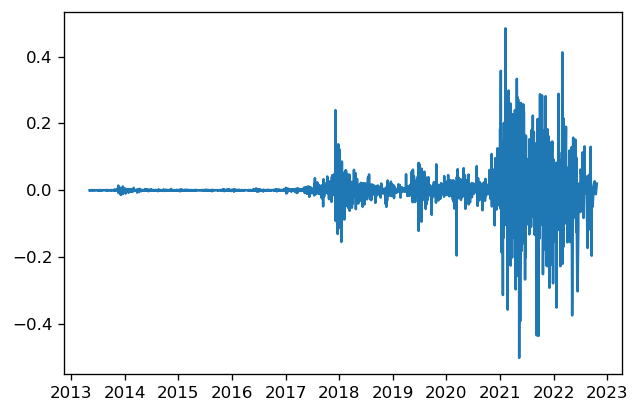

In [11]:
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})
plt.plot(btc['close'])

In [12]:
annual_volatility = btc['close'].groupby(btc.index.year).std()
annual_volatility

date
2013    0.002669
2014    0.001492
2015    0.000674
2016    0.000983
2017    0.026705
2018    0.025528
2019    0.021038
2020    0.027610
2021    0.136235
2022    0.109575
Name: close, dtype: float64

In [13]:
close_annual_vol = btc['close'].index.map(lambda d: annual_volatility.loc[d.year])
close_annual_vol

Float64Index([0.0026692489156595754, 0.0026692489156595754,
              0.0026692489156595754, 0.0026692489156595754,
              0.0026692489156595754, 0.0026692489156595754,
              0.0026692489156595754, 0.0026692489156595754,
              0.0026692489156595754, 0.0026692489156595754,
              ...
                0.10957535754248365,   0.10957535754248365,
                0.10957535754248365,   0.10957535754248365,
                0.10957535754248365,   0.10957535754248365,
                0.10957535754248365,   0.10957535754248365,
                0.10957535754248365,   0.10957535754248365],
             dtype='float64', name='date', length=3247)

In [14]:
btc['close'] = btc['close'] / close_annual_vol

Text(0.5, 1.0, 'BTC Close Votality Reduced')

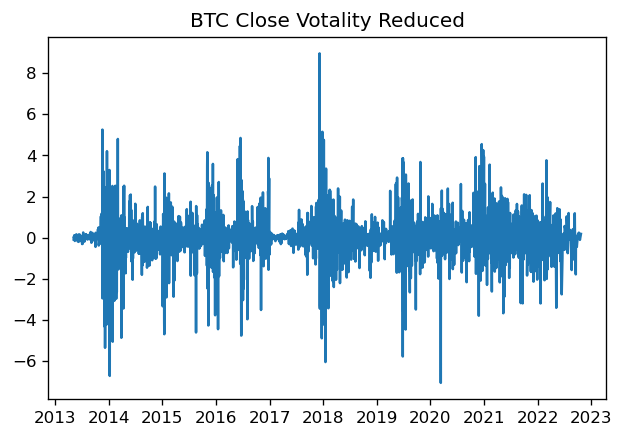

In [15]:
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})
plt.plot(btc['close'])
plt.title('BTC Close Votality Reduced', fontsize=12)

### Data cleaning for other columns (open, high, low)

We will apply the same process we did above: make the data stationary, remove votality and seasonality for *open*, *high* and *low* columns of btc.

In [16]:
# remove votality
annual_volatility_open = btc['open'].groupby(btc.index.year).std()
open_annual_vol = btc['open'].index.map(lambda d: annual_volatility.loc[d.year])
btc['open'] = btc['open'] / open_annual_vol

annual_volatility_open = btc['high'].groupby(btc.index.year).std()
high_annual_vol = btc['high'].index.map(lambda d: annual_volatility.loc[d.year])
btc['high'] = btc['high'] / high_annual_vol

annual_volatility_open = btc['low'].groupby(btc.index.year).std()
low_annual_vol = btc['low'].index.map(lambda d: annual_volatility.loc[d.year])
btc['low'] = btc['low'] / low_annual_vol

Text(0, 0.5, 'close')

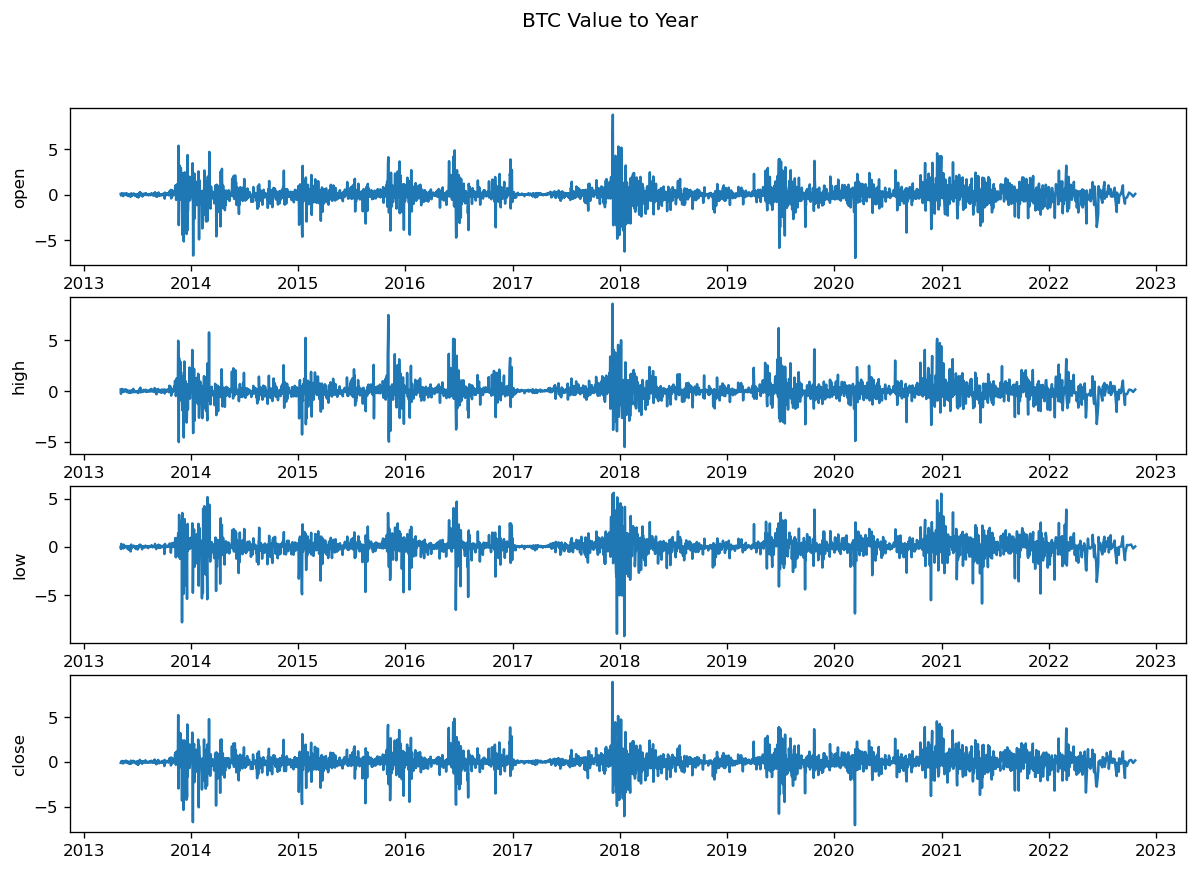

In [17]:
# Plot
plt.rcParams.update({'figure.figsize': (12,8)})
fig, axs = plt.subplots(4)
fig.suptitle('BTC Value to Year')
axs[0].plot(btc['open'])
axs[0].set_ylabel('open')
axs[1].plot(btc['high'])
axs[1].set_ylabel('high')
axs[2].plot(btc['low'])
axs[2].set_ylabel('low')
axs[3].plot(btc['close'])
axs[3].set_ylabel('close')

## Model Training

This part is *purely experimental learning* of LSTM model using the following reference:
https://www.kaggle.com/code/miracl16/tesla-stock-price-prediction-lstm-vs-gru

In [18]:
# Find the desired year to predict (create a test set corresponding to that year)
def find_year(year):
    return len(btc[btc.index < pd.to_datetime(year, format = '%Y')].values)

In [19]:
# num_shape seperates train set and test set
num_shape = find_year(2021)

train = btc.iloc[:num_shape, 1:2].values
test = btc.iloc[num_shape:, 1:2].values

In [20]:
# Normalize the data
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(train)

In [21]:
X_train = []

# Price on next day
y_train = []

window = 60

for i in range(window, num_shape):
    X_train_ = np.reshape(train_scaled[i-window:i, 0], (window, 1))
    X_train.append(X_train_)
    y_train.append(train_scaled[i, 0])
X_train = np.stack(X_train)
y_train = np.stack(y_train)

In [22]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Initializing the Recurrent Neural Network
model = Sequential()
# Adding the first LSTM layer with a sigmoid activation function and some Dropout regularization
# Units - dimensionality of the output space

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))
model.summary()

2023-02-12 03:28:57.998210: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 50)            10400     
_________________________________________________________________
dropout (Dropout)            (None, 60, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                2

In [23]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 10, batch_size = 32);

2023-02-12 03:28:59.447224: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
86/86 [==============================] - 26s 203ms/step - loss: 0.0138
Epoch 2/10
86/86 [==============================] - 17s 197ms/step - loss: 0.0057
Epoch 3/10
86/86 [==============================] - 17s 194ms/step - loss: 0.0055
Epoch 4/10
86/86 [==============================] - 17s 192ms/step - loss: 0.0055
Epoch 5/10
86/86 [==============================] - 17s 195ms/step - loss: 0.0055
Epoch 6/10
86/86 [==============================] - 16s 191ms/step - loss: 0.0053
Epoch 7/10
86/86 [==============================] - 17s 196ms/step - loss: 0.0054
Epoch 8/10
86/86 [==============================] - 16s 188ms/step - loss: 0.0051
Epoch 9/10
86/86 [==============================] - 17s 195ms/step - loss: 0.0051
Epoch 10/10
86/86 [==============================] - 17s 195ms/step - loss: 0.0051


In [24]:
df_volume = np.vstack((train, test))

inputs = df_volume[df_volume.shape[0] - test.shape[0] - window:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

num_2 = df_volume.shape[0] - num_shape + window

X_test = []

for i in range(window, num_2):
    X_test_ = np.reshape(inputs[i-window:i, 0], (window, 1))
    X_test.append(X_test_)
    
X_test = np.stack(X_test)

In [25]:
# Use model to predict future dataset
predict = model.predict(X_test)
predict = sc.inverse_transform(predict)

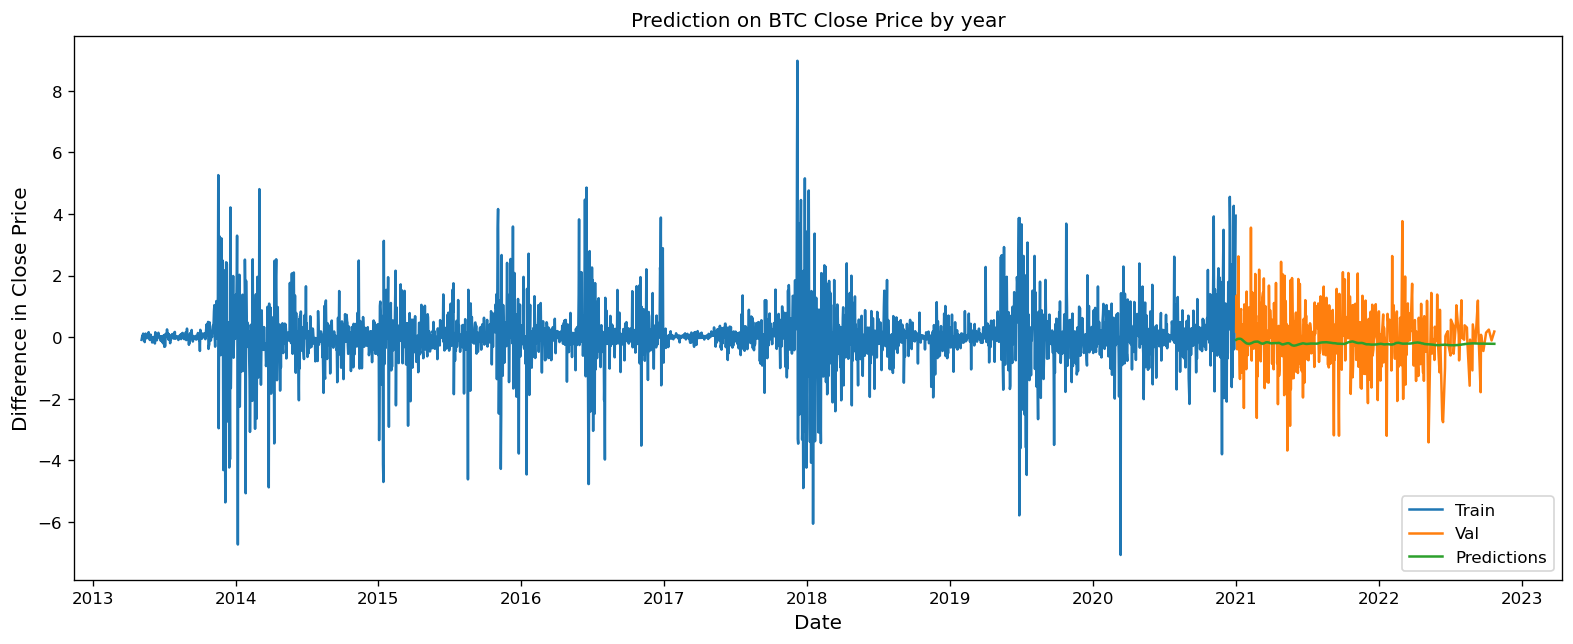

In [26]:
# Plot the data
data = btc.filter(['close'])
train = data[:num_shape]
valid = data[num_shape:]
valid['Predictions'] = predict
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Prediction on BTC Close Price by year')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Difference in Close Price', fontsize=12)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [27]:
# Simple validation of the model
from sklearn.metrics import precision_score
valid["Tomorrow"] = valid["close"].shift(-1)
valid["Tomorrow_Predictions"] = valid["Predictions"].shift(-1)
valid["Target"] = (valid["Tomorrow"] > valid["close"]).astype(int)
valid["Target_Predictions"] = (valid["Tomorrow_Predictions"] > valid["Predictions"]).astype(int)
print("Evaluating the model")
print("Root mean squared error: ", np.sqrt(np.mean((predict - test)**2)))
print("Precision score: ", precision_score(valid["Target_Predictions"], valid["Target"]))

Evaluating the model
Root mean squared error:  0.9986892943043523
Precision score:  0.47345132743362833
